In [3]:
!pip install git+https://github.com/rtqichen/torchdiffeq.git

  Cloning https://github.com/rtqichen/torchdiffeq.git to /tmp/pip-req-build-trkjauox
  Running command git clone -q https://github.com/rtqichen/torchdiffeq.git /tmp/pip-req-build-trkjauox
  Created wheel for torchdiffeq: filename=torchdiffeq-0.0.1-cp36-none-any.whl size=25885 sha256=6d4d542f93062ac94322a77ba1e41b75c20cf45457d317ec18dd8de21fe509f1
  Stored in directory: /tmp/pip-ephem-wheel-cache-c9d12c2a/wheels/f1/89/ce/78b4c1aabbb8dad56a2dbd776f9ffcbeca103b2ddae40d094b
Successfully built torchdiffeq


In [4]:
project_dir = "odenet"
import sys
if True: # On colab
    from google.colab import drive
    drive.mount('/content/drive',force_remount=True)
    root = "/content/drive/My Drive/Colab Notebooks/"+project_dir
    sys.path.append(root)
else: # Local
    root = './'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import torch
import torchvision
from matplotlib import pylab as plt
import torchdiffeq
import copy

In [0]:
from models import *

# cifar10

In [0]:
transform_train = torchvision.transforms.Compose([
    torchvision.transforms.RandomCrop(32, padding=4),
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

In [0]:
refset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=None)
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


In [0]:
for i in range(2):
    plt.imshow(refset[i][0])
    plt.show()

# Fashion MNIST

In [7]:
transform = torchvision.transforms.Compose([
                torchvision.transforms.ToTensor(),
                torchvision.transforms.Normalize((0.5,),
                                                 (0.5,)),
            ])
refset = torchvision.datasets.FashionMNIST('F_MNIST_data/', download=True, train=True, transform=None)
trainset = torchvision.datasets.FashionMNIST('F_MNIST_data/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
testset = torchvision.datasets.FashionMNIST('F_MNIST_data/', download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)

  0%|          | 106496/26421880 [00:00<00:25, 1030469.53it/s]

26427392it [00:00, 82941315.63it/s]                             


Extracting F_MNIST_data/FashionMNIST/raw/train-images-idx3-ubyte.gz to F_MNIST_data/FashionMNIST/raw


32768it [00:00, 576672.58it/s]
 10%|▉         | 434176/4422102 [00:00<00:00, 4078106.30it/s]

Extracting F_MNIST_data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to F_MNIST_data/FashionMNIST/raw


4423680it [00:00, 29438400.95it/s]                           
8192it [00:00, 179865.67it/s]


Extracting F_MNIST_data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to F_MNIST_data/FashionMNIST/raw
Extracting F_MNIST_data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to F_MNIST_data/FashionMNIST/raw
Processing...
Done!


In [0]:
def channel_squish(imgs, sq):
    """TODO: Only works without channels right now"""
    W,H = imgs.shape[-2],imgs.shape[-1]
    C = imgs.shape[1]
    ii = imgs.reshape(-1, W, H//sq, sq).permute(0,2,1,3).reshape(-1,W//sq, H//sq, sq*sq).permute(0,3,2,1)
    return ii


## We need a few baselines

In [0]:
class MyClassifier(torch.nn.Module):
    def __init__(self):
        super(MyClassifier,self).__init__()
        self.net = torch.nn.Sequential(
            torch.nn.Linear(784,784),
            torch.nn.ReLU(),
            torch.nn.Linear(784,784),
            torch.nn.ReLU(),
            torch.nn.Linear(784,10),
        )
    def foward(self,x):
        return self.net(x)

# RefineNet

The ODE needs to be cut up when the information decreases.

In [0]:
class MyResNet(torch.nn.Module):
    def __init__(self):
        super(MyResNet,self).__init__()
        self.net = torch.nn.Sequential(
            torch.nn.Conv2d(1,16,1),
            ODEBlock(ConvODE(16,16)),
            torch.nn.MaxPool2d(3),
            ODEBlock(ConvODE(16,16)),
            torch.nn.MaxPool2d(3),
            torch.nn.Flatten(),
            torch.nn.Linear(16*3*3,10),
        )
    def forward(self,x):
        return self.net(x)
    def refine(self):
        new = copy.deepcopy(self)
        for i in range(len(self.net)):
            new.net[i] = refine(self.net[i])
        return new

class PureRefineNet(torch.nn.Module):
    def __init__(self, ode_width=4, inner_width=8):
        super(PureRefineNet,self).__init__()
        self.net = torch.nn.Sequential(
            ODEBlock(ConvODE(ode_width,inner_width)),
            torch.nn.AdaptiveAvgPool2d((3,3)),
            torch.nn.Flatten(),
            torch.nn.Linear(ode_width*3*3,10),
        )
    def forward(self,x):
        y = channel_squish(x,2)
        return self.net(y)
    def refine(self):
        new = copy.deepcopy(self)
        for i in range(len(self.net)):
            new.net[i] = refine(self.net[i])
        return new

class ConvODE(torch.nn.Module):
    def __init__(self,i_width=16, h_width=16):
        super(ConvODE,self).__init__()
        self.net = torch.nn.Sequential(
            torch.nn.Conv2d(i_width,h_width,3, padding=True),
            torch.nn.ReLU(),
            torch.nn.Conv2d(h_width,i_width,3, padding=True),
            torch.nn.ReLU()
        )
    def forward(self,t,x):
        return self.net(x)
    def refine(self):
        return copy_model(self)

In [24]:
print(imgs.shape)
ii = imgs.reshape(-1,28,14,2).permute(0,2,1,3).reshape(-1,14,14,4).permute(0,3,2,1)
print(ii.shape)

torch.Size([64, 1, 28, 28])
torch.Size([64, 4, 14, 14])


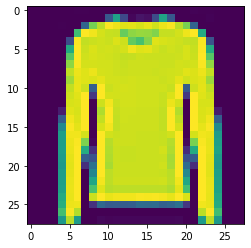

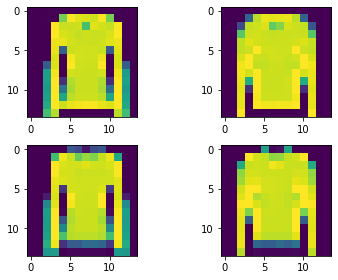

In [49]:
plt.imshow(imgs[3,0,:,:])
ii = channel_squish(imgs, 2)
plt.show()
for i in range(4):
    plt.subplot(2,2,i+1)
    plt.imshow(ii[3,i,:,:])
plt.tight_layout()
plt.show()
    

In [0]:
N_epochs=1

In [0]:
def train_for_epochs(model, N_epochs, 
                     losses= None, test_losses = None, step_count = 0,
                     N_print = 100, lr=1.0e-1):
    if losses is None: losses = []
    if test_losses is None: test_losses = []
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    for e in range(N_epochs):
        for imgs,labels in iter(trainloader):
            #imgs = imgs.reshape(-1,784)
            #print(imgs.shape)
            optimizer.zero_grad()
            out = model(imgs)
            L = criterion(out,labels)
            L.backward()
            optimizer.step()
            losses.append(L.detach().numpy())
            if step_count % N_print == N_print-1:
                testimgs,testlabels = next(iter(testloader))
                with torch.no_grad():
                    pred = model(testimgs)
                    test_L = criterion(pred,testlabels)
                    test_losses.append((step_count,L.detach().item()))
                print(L.detach(),test_L.detach())
            step_count += 1
    return step_count

In [0]:
model = PureRefineNet()

In [86]:
models = [model] # Saves pointers to the models
losses = [] # Save the total history of the train loss
test_losses = [] # And the test_loss
refine_steps = [] # saves the stages when refinement occured
N_refinement = 3
step_count = 0
for i in range(N_refinement):
    if i > 0:
        models.append( models[-1].refine() )
        print("Adapting to size ",count_parameters(models[-1]))
    else:
        print("Starting with size",count_parameters(models[-1]))
    step_count += train_for_epochs(models[-1], 1, losses, test_losses, step_count=step_count,
                                   lr=1.0**(-i-1))
    refine_steps.append(len(losses))

Starting with size 958
tensor(2.9706) tensor(2.2819)
tensor(1.5570) tensor(1.1143)
tensor(2.4260) tensor(1.4361)
tensor(2.3350) tensor(1.5898)
tensor(1.4318) tensor(1.2816)
tensor(1.8067) tensor(1.1483)
tensor(1.1666) tensor(1.2069)
tensor(1.7805) tensor(1.9492)
tensor(1.3994) tensor(1.6611)
Adapting to size  1546
tensor(2.2645) tensor(2.3417)
tensor(1.6775) tensor(1.9766)
tensor(2.0639) tensor(1.4425)
tensor(1.2800) tensor(2.3078)
tensor(3.4185) tensor(1.9858)
tensor(3.2742) tensor(1.4808)
tensor(2.6328) tensor(2.5367)
tensor(1.2876) tensor(1.8239)
tensor(2.8184) tensor(2.5515)
Adapting to size  2722
tensor(2.4508) tensor(3.6780)
tensor(1.8952) tensor(4.2723)
tensor(1.9453) tensor(1.3397)
tensor(2.1026) tensor(1.9352)
tensor(1.9138) tensor(4.1419)
tensor(2.4806) tensor(1.0999)
tensor(1.8901) tensor(2.0478)
tensor(2.3473) tensor(5.0413)
tensor(1.7555) tensor(2.1751)


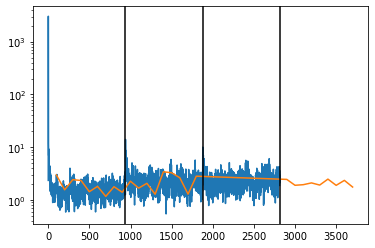

In [87]:
plt.semilogy(losses)
plt.semilogy([x for x,y in test_losses], [y for x,y in test_losses])
for r in refine_steps:
    plt.axvline(r,color='k')

In [0]:
def plot_accuracy(model):
    imgs,labels = next(iter(trainloader))
    res = torch.nn.Softmax(dim=-1)(model(imgs[:10,:,:,:]))
    size = len(res)
    plt.figure(figsize=(10,10))
    for i,(pred,img,label) in enumerate(zip(res,imgs,labels)):
        plt.subplot(size//2+1,4,1+2*i)
        plt.imshow(img[0,:,:].detach().numpy(),cmap='Greys')
        plt.subplot(size//2+1,4,2+2*i)
        plt.bar(range(10),[1 if y==label else 0 for y in range(10)])
        plt.bar(range(10),pred.detach().numpy())
    plt.show()

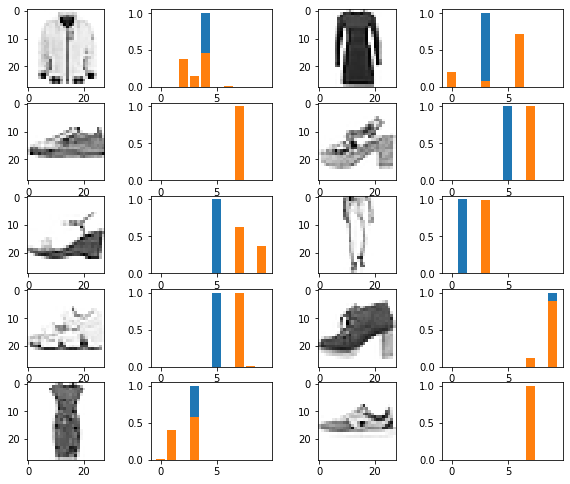

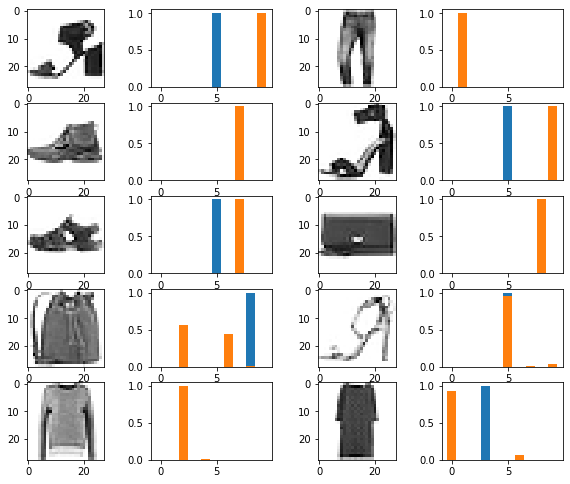

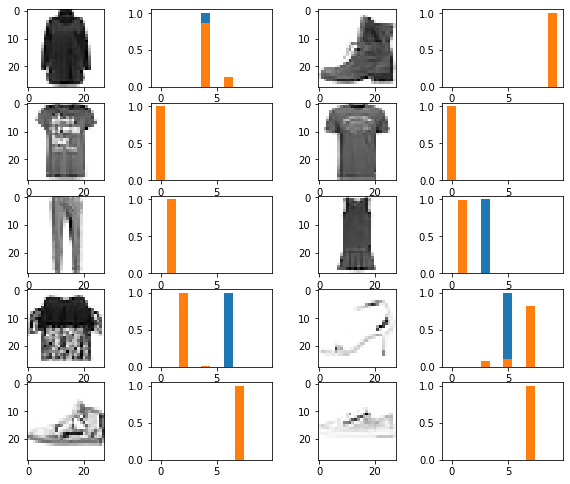

In [91]:
for m in models:
    plot_accuracy(m)

In [0]:
trainset.classes

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']